# Hydrological Modelling

In [18]:
#import modules (basic)
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns


#ML packages
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import catboost as cb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

colors = sns.color_palette("colorblind")
colors2 = sns.color_palette("Set2")

In [24]:
#Where to split?
split_date="2011-01-01"



Data="../AAC2312/Data/PTQ_old.txt"

#Lag settings:
lag_true = True
lags = [i for i in range(1, 21)]

#Load Dataset
data_csv= pd.read_table(Data)

print(data_csv.head())
data_csv["Date"]=pd.to_datetime(data_csv['Date'], format="%Y%m%d")

#split into test and trainset
row = data_csv.loc[data_csv['Date'] == pd.Timestamp(split_date)]
train_set_raw=data_csv[:row.index[0]]
test_set_raw=data_csv[row.index[0]:]

print(f"Train set: {len(train_set_raw)} observations, {round((len(train_set_raw)/len(data_csv))*100)}% of the whole Dataset")
print(f"Test set: {len(test_set_raw)} observations, {round((len(test_set_raw)/len(data_csv))*100)}% of the whole Dataset")
train_set_raw.head(2)


       Date      P      T       Q
0  19800101  0.193 -0.131  1.7626
1  19800102  1.823 -1.666  1.4692
2  19800103  1.825 -2.099  1.2759
3  19800104  7.815 -2.027  1.1848
4  19800105  5.314  2.661  2.1983
Train set: 11323 observations, 78% of the whole Dataset
Test set: 3103 observations, 22% of the whole Dataset


,Date,P,T,Q
0,1980-01-01,0.193,-0.131,1.7626
1,1980-01-02,1.823,-1.666,1.4692


[]

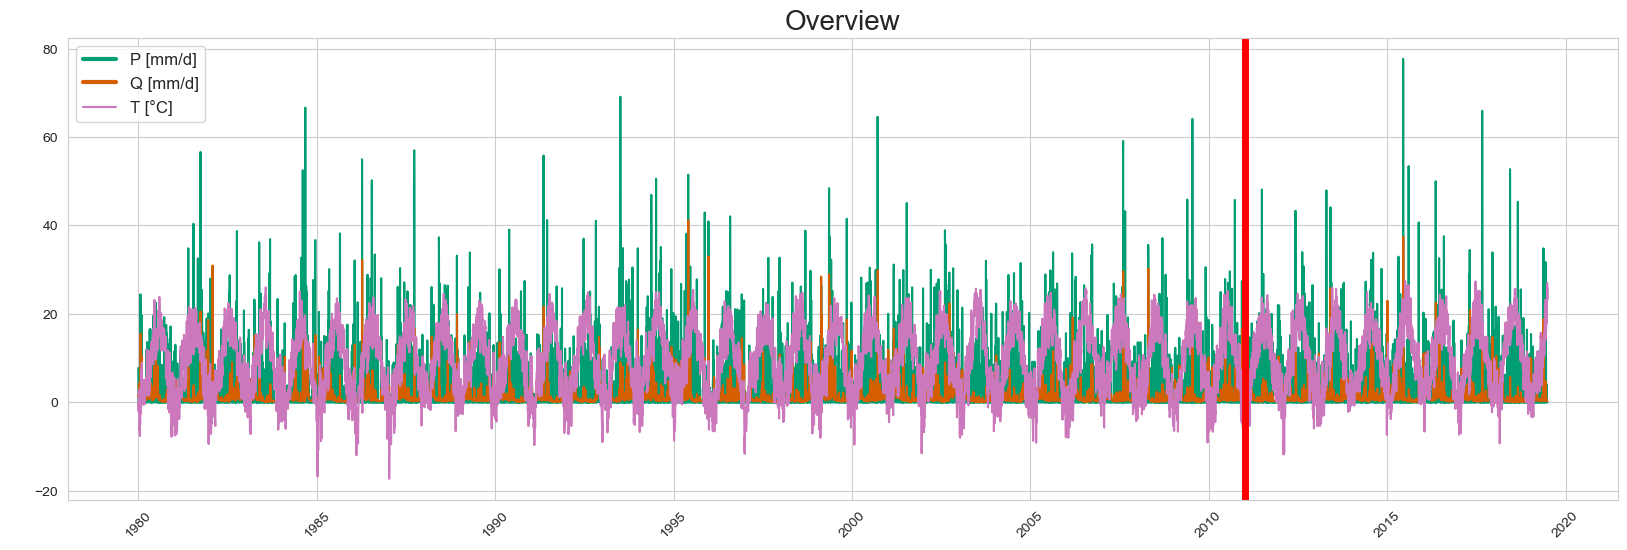

In [26]:
plt.figure(figsize=(20, 6))
plt.plot(data_csv["Date"],data_csv["P"],label="P [mm/d]",color=colors[2])
plt.plot(data_csv["Date"],data_csv["Q"],label="Q [mm/d]",color=colors[3])
plt.plot(data_csv["Date"],data_csv["T"],label="T [°C]",color=colors[4])

#Vertical Line
plt.axvline(x=pd.Timestamp(split_date)+ pd.DateOffset(2),color="red",linewidth=5)
#plt.axvline(x=pd.Timestamp(split_date)- pd.DateOffset(2),color="blue",linewidth=5)

#Arrows
#plt.arrow(pd.Timestamp(split_date)+ pd.DateOffset(4),30,120,0,head_width=2, head_length=15, fc='red', ec='red',linewidth=5)
#plt.text(pd.Timestamp(split_date)+ pd.DateOffset(15), 27.5, "Test data", fontsize=25,color="red")
#plt.arrow(pd.Timestamp(split_date)- pd.DateOffset(4),30,-150,0,head_width=2, head_length=15, fc='blue', ec='blue',linewidth=5)
#plt.text(pd.Timestamp(split_date)- pd.DateOffset(100), 27.5, "Train data", fontsize=25,color="blue")
plt.xticks(rotation=45)

#Other things
plt.title("Overview", fontdict={'fontsize': 20})
plt.ylabel(" ", fontdict={'fontsize': 15})
legend=plt.legend(loc="upper left",fontsize="12")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3
plt.plot()

In [56]:
#create time - lag <- TRUE equals it will create time-lag
if True:
    for i in lags:
        string_p="P"+str(i)
        string_t="T"+str(i)

        test_set_raw[string_p]= test_set_raw['P'].shift(i)
        train_set_raw[string_p]= train_set_raw['P'].shift(i)

        test_set_raw[string_t]= test_set_raw['T'].shift(i)
        train_set_raw[string_t]= train_set_raw['T'].shift(i)

    test_set_raw=test_set_raw.dropna()
    train_set_raw=train_set_raw.dropna()

C:\Users\claud\AppData\Local\Temp\ipykernel_18040\2320453074.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_raw[string_p]= test_set_raw['P'].shift(i)
C:\Users\claud\AppData\Local\Temp\ipykernel_18040\2320453074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_raw[string_p]= train_set_raw['P'].shift(i)
C:\Users\claud\AppData\Local\Temp\ipykernel_18040\2320453074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind


# What is Gradient Boosting Regression? (Theory)


In [57]:
test_set = test_set_raw.copy()
train_set = train_set_raw.copy()

In [58]:
#CODE:
def apply_table_styles(df):
    return df.style.set_table_styles(
        [
            {
                'selector': 'th',
                'props': [('background-color', 'lightgray')]
            },
            {
                'selector': 'tbody tr:nth-child(even)',
                'props': [('background-color', "lightblue")]
            }
        ]
    )


comparison_dict = {
    'Algorithm': ['Random Forest', 'Gradient Boosting Regression'],
    'Training approach': ['Independent and parallel', 'Sequential and residuals'],
    'Bias-variance tradeoff': ['Higher bias, lower variance', 'Lower bias, higher variance'],
    'Speed': ['Faster for large datasets', 'Slower for large datasets'],
    'Hyperparameters': ['Number of trees, maximum depth', 'Learning rate, number of trees'],
    'Interpretability': ['Lower', 'Higher'],
    'Handling missing values': ['Able to handle missing values', 'Not able to handle missing values'],
    'Robustness to outliers': ['More robust', 'Less robust'],
    'Model performance': ['Stable performance', 'Tendency to overfit']
}

# Convert the dictionary to a pandas DataFrame
comparison_df = pd.DataFrame.from_dict(comparison_dict).T.rename_axis('Algorithm', axis=1).drop(index="Algorithm")
comparison_df.columns = ['Random Forest', 'Gradient Boosting Regression']

# Create a simple dataset
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel()


# Create Gradient Boosting Regression model
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)

# Train model on data
gbr.fit(X, y)
comparison_df

,Random Forest,Gradient Boosting Regression
Training approach,Independent and parallel,Sequential and residuals
Bias-variance tradeoff,"Higher bias, lower variance","Lower bias, higher variance"
Speed,Faster for large datasets,Slower for large datasets
Hyperparameters,"Number of trees, maximum depth","Learning rate, number of trees"
Interpretability,Lower,Higher
Handling missing values,Able to handle missing values,Not able to handle missing values
Robustness to outliers,More robust,Less robust
Model performance,Stable performance,Tendency to overfit


### What is this algorithm (simple explanation):

The GBR works by combining many decision trees. Each tree tries to fix the mistakes made by the previous trees. The trees are added together, creating an ensemble that makes a prediction.

The hyperparameters of GBR include the number of trees in the ensemble (n_estimators), the learning rate (learning_rate) that controls the contribution of each tree to the ensemble, and the maximum depth of each tree (max_depth), among others.

-> These hyperparameters need to be tuned carefully to obtain the best performance from the model. So we will use the CrossValidationCV module, which is quite good.

An decision tree is visualized below:


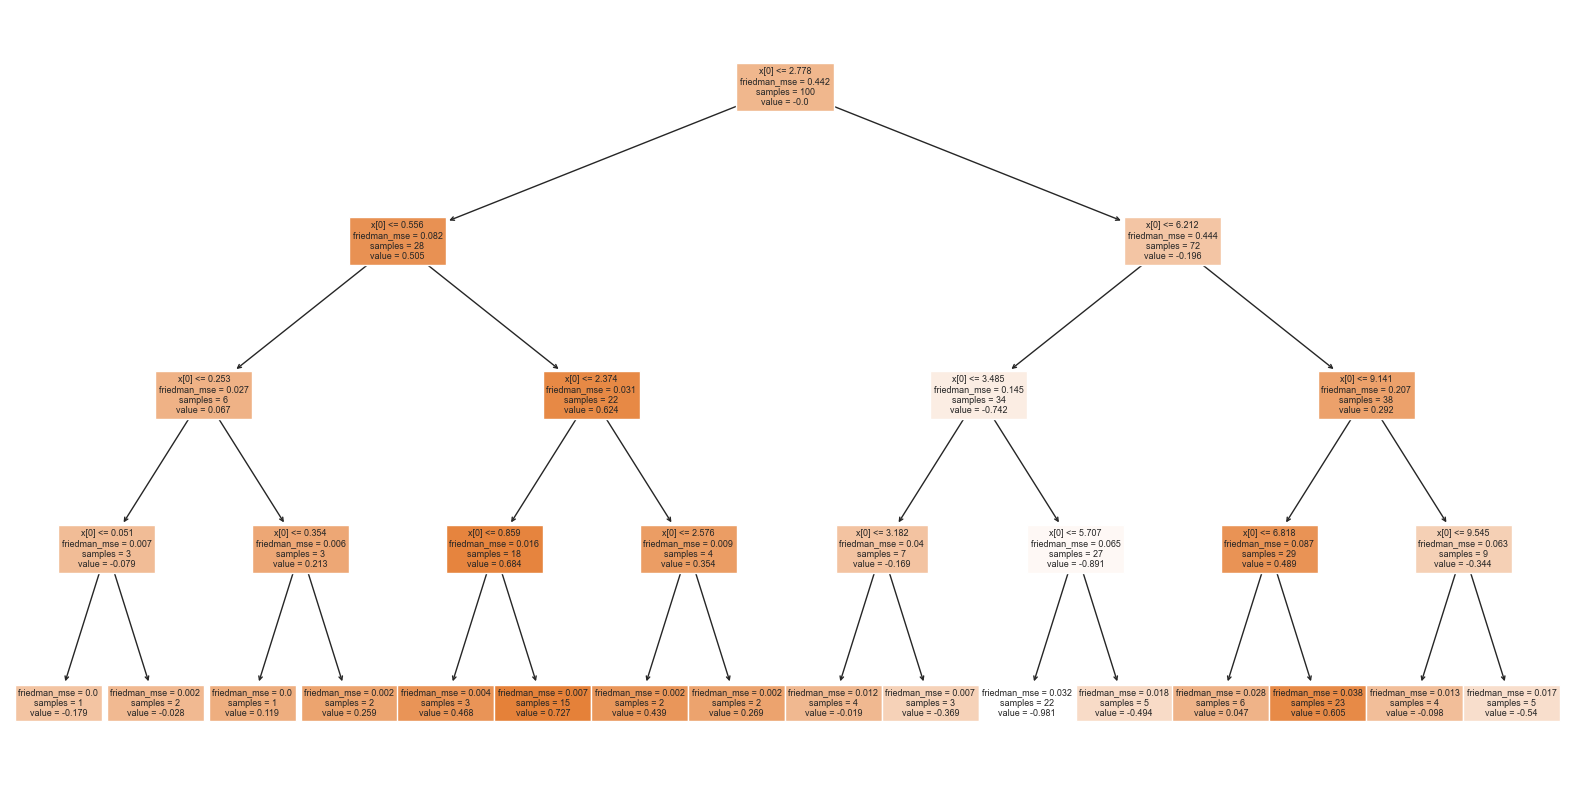

In [59]:
plt.figure(figsize=(20, 10))
plot_tree(gbr.estimators_[0, 0], filled=True)
plt.show()

# Coding (Random Forest Regression)

without time lag it is very shit. lets try with time_lag

In [68]:
test_set=test_set_raw.copy()
train_set=train_set_raw.copy()

In [69]:
#Grid search is quite useful here:
#define the parameters to choose from
start_time = datetime.now()

param_grid = {
    "criterion": ["squared_error"],
    "max_depth": [9,12],
    #"min_samples_split": [2]
}
#define the scorer
#scorer = make_scorer(r2_score)
scorer = make_scorer(mean_absolute_error)

#initialize the model:
rfr = RandomForestRegressor()

#make the GridSearch:

grid_search1 = HalvingGridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=5, #
    n_jobs=-1, #use 1 core of the CPU
    verbose=10,#print progress messages
    factor=2,
    resource="n_estimators",
    max_resources=20
)
#fit it to the train-set: if False, the fitted model will be loaded from disk:
grid_search1.fit(train_set.drop(columns=["Q","Date"]),train_set["Q"])


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)


end_time = datetime.now()    # Get the time after the function execution
execution_time1 = end_time - start_time

test_set["Q_predicted_RandomForest"]= grid_search1.predict(test_set.drop(columns=["Q","Date"]))


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)

mse_1=mean_squared_error(test_set["Q_predicted_RandomForest"],test_set["Q"])
r2_1=r2_score(test_set["Q"],test_set["Q_predicted_RandomForest"])
n = len(test_set["Q"])  # number of observations
p = 2  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_1) * (n - 1) / (n - p - 1)

print("Best Score (mse):",mse_1)
print("Best Score (r2):",r2_1)
print("n",n)
print("Best Score (r2_adjusted):",r2_adjusted)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 10
max_resources_: 20
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 10
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 1
n_candidates: 1
n_resources: 20
Fitting 5 folds for each of 1 candidates, totalling 5 fits
----------------------------
Best Parameters: {'criterion': 'squared_error', 'max_depth': 9, 'n_estimators': 20}
Best Score (mae): 0.5644609612528961
----------------------------
Best Parameters: {'criterion': 'squared_error', 'max_depth': 9, 'n_estimators': 20}
Best Score (mae): 0.5644609612528961
Best Score (mse): 1.4966796847529775
Best Score (r2): 0.6321155244583492
n 3083
Best Score (r2_adjusted): 0.6318766384352701


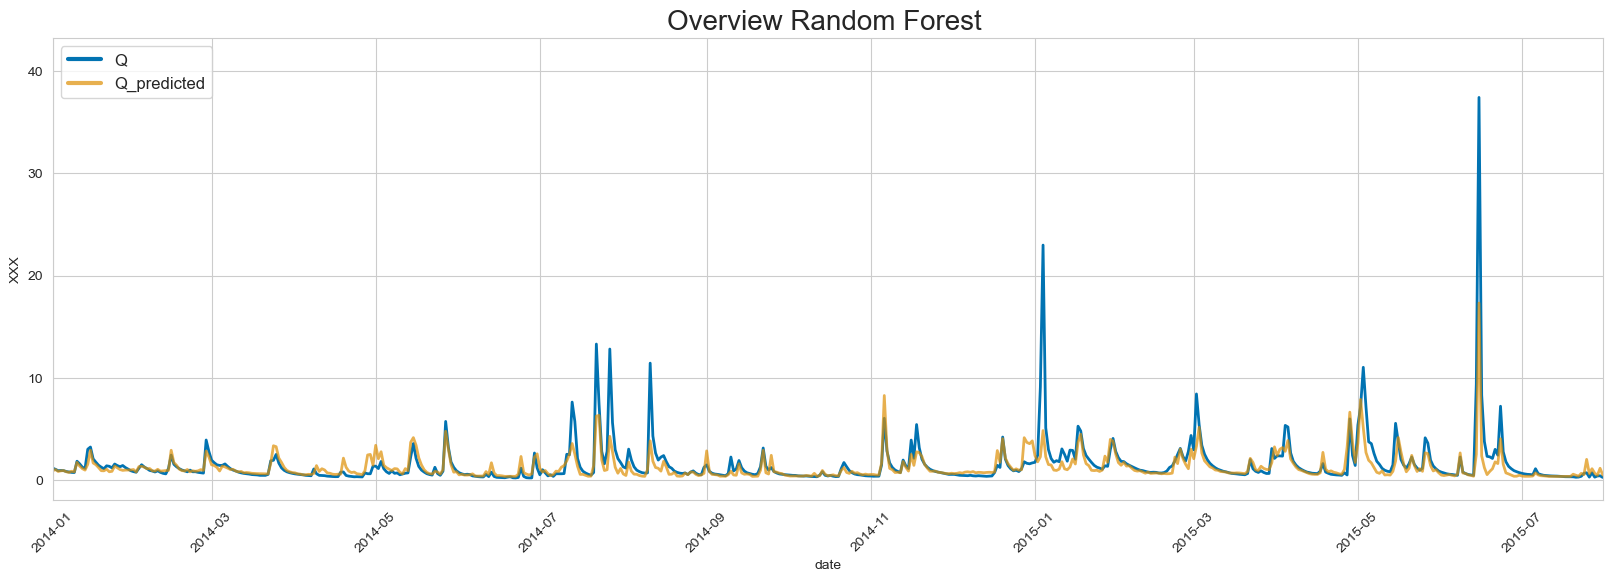

In [70]:
#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(data_csv["Date"],data_csv["Q"],label="Q", color=colors[0],alpha=1,linewidth =2)
plt.plot(test_set["Date"],test_set["Q_predicted_RandomForest"],label="Q_predicted", color=colors[1],alpha=0.7,linewidth =2)

#Other things
plt.title("Overview Random Forest ", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2015-07-31"))
plt.ylabel("XXX")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

# CatBoost Attempt

In [72]:
#Grid search is quite useful here:
#define the parameters to choose from
start_time = datetime.now()

param_grid = {
    'learning_rate': [0.1],
    'max_depth': [5, 7, 9],
    'n_estimators': [1000],
    'num_leaves': [10, 20, 31]
}
#define the scorer
#scorer = make_scorer(r2_score)
#define the scorer, in this case we can use the mean squared error:

scorer = {
    'mse': make_scorer(mean_squared_error, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}#initialize the model:
rfr = cb.CatBoostRegressor()

#make the GridSearch:

grid_search2 = GridSearchCV(
    estimator=rfr, #implement the GradienBoostingRegressor
    param_grid=param_grid, #the defined parameters (see above)
    scoring=scorer,
    cv=5, #5-fold Cross Validation -> quite normal here!
    n_jobs=-1, #use 1 core of the CPU,
    refit='mse',
    verbose=10,#print progress messages
)

#fit it to the train-set: if False, the fitted model will be loaded from disk:
grid_search2.fit(train_set.drop(columns=["Q","Date"]),train_set["Q"])


#get the best hyperparameters and the mse:
best_params = grid_search1.best_params_
best_score = grid_search1.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)


end_time = datetime.now()    # Get the time after the function execution
execution_time2 = end_time - start_time

test_set["Q_predicted_CatBoost"]= grid_search2.predict(test_set.drop(columns=["Q","Date","Q_predicted_RandomForest"]))


#get the best hyperparameters and the mse:
best_params = grid_search2.best_params_
best_score = grid_search2.best_score_
print("----------------------------")
print("Best Parameters:",best_params)
print("Best Score (mae):",best_score)

mse_2=mean_squared_error(test_set["Q_predicted_CatBoost"],test_set["Q"])
r2_2=r2_score(test_set["Q"],test_set["Q_predicted_CatBoost"])
n = len(test_set["Q"])  # number of observations
p = 2  # number of predictors (features)
r2_adjusted = 1 - (1 - r2_1) * (n - 1) / (n - p - 1)

print("Best Score (mse):",mse_2)
print("Best Score (r2):",r2_2)
print("n",n)
print("Best Score (r2_adjusted):",r2_adjusted)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\ProgramData\Anaconda3\envs\Zonal_Generatuor_new\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\Zonal_Generatuor_new\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\Zonal_Generatuor_new\lib\site-packages\catboost\core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "C:\Pr

0:	learn: 1.9377217	total: 3.96ms	remaining: 3.95s
1:	learn: 1.8644590	total: 7.58ms	remaining: 3.78s
2:	learn: 1.7970964	total: 10.9ms	remaining: 3.62s
3:	learn: 1.7357239	total: 14.3ms	remaining: 3.55s
4:	learn: 1.6736109	total: 17.6ms	remaining: 3.5s
5:	learn: 1.6222338	total: 21.1ms	remaining: 3.5s
6:	learn: 1.5721427	total: 24.7ms	remaining: 3.51s
7:	learn: 1.5259667	total: 28.3ms	remaining: 3.5s
8:	learn: 1.4876991	total: 32ms	remaining: 3.52s
9:	learn: 1.4511043	total: 35.6ms	remaining: 3.52s
10:	learn: 1.4147974	total: 39.3ms	remaining: 3.53s
11:	learn: 1.3809406	total: 43ms	remaining: 3.54s
12:	learn: 1.3553775	total: 46.8ms	remaining: 3.55s
13:	learn: 1.3310981	total: 50.8ms	remaining: 3.58s
14:	learn: 1.3054400	total: 54.7ms	remaining: 3.59s
15:	learn: 1.2815918	total: 58.4ms	remaining: 3.59s
16:	learn: 1.2613875	total: 62.3ms	remaining: 3.6s
17:	learn: 1.2431164	total: 66ms	remaining: 3.6s
18:	learn: 1.2254975	total: 71.1ms	remaining: 3.67s
19:	learn: 1.2084761	total: 74.8m

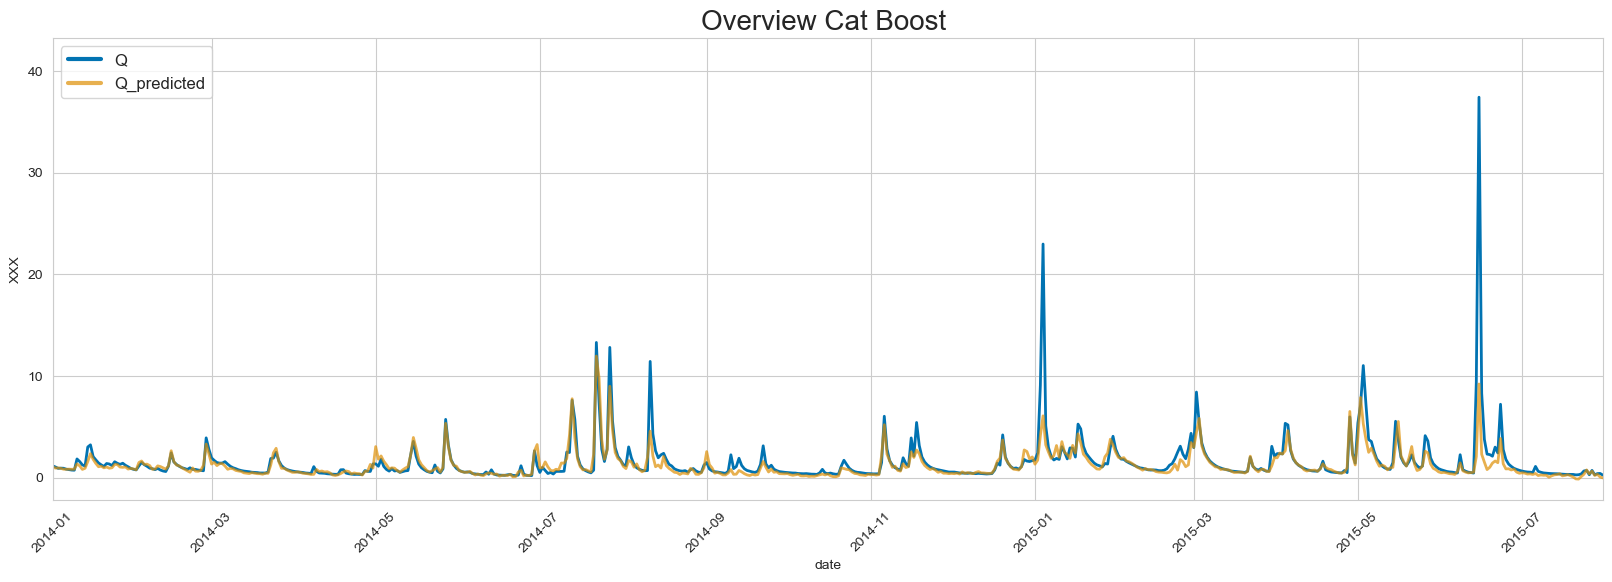

In [74]:
#SUBSET of Timeseries:
plt.figure(figsize=(20, 6))
plt.plot(data_csv["Date"],data_csv["Q"],label="Q", color=colors[0],alpha=1,linewidth =2)
plt.plot(test_set["Date"],test_set["Q_predicted_CatBoost"],label="Q_predicted", color=colors[1],alpha=0.7,linewidth =2)

#Other things
plt.title("Overview Cat Boost ", fontdict={'fontsize': 20})
plt.xlabel("date")
plt.xticks(rotation=45)
plt.xlim(pd.Timestamp(split_date))
plt.xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2015-07-31"))
plt.ylabel("XXX")
legend=plt.legend(fontsize="12",loc="upper left")
legend.get_lines()[0].set_linewidth(3) # Set linewidth to 3
legend.get_lines()[1].set_linewidth(3) # Set linewidth to 3

# Plot overview

C:\Users\claud\AppData\Local\Temp\ipykernel_18040\3415783909.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
C:\Users\claud\AppData\Local\Temp\ipykernel_18040\3415783909.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


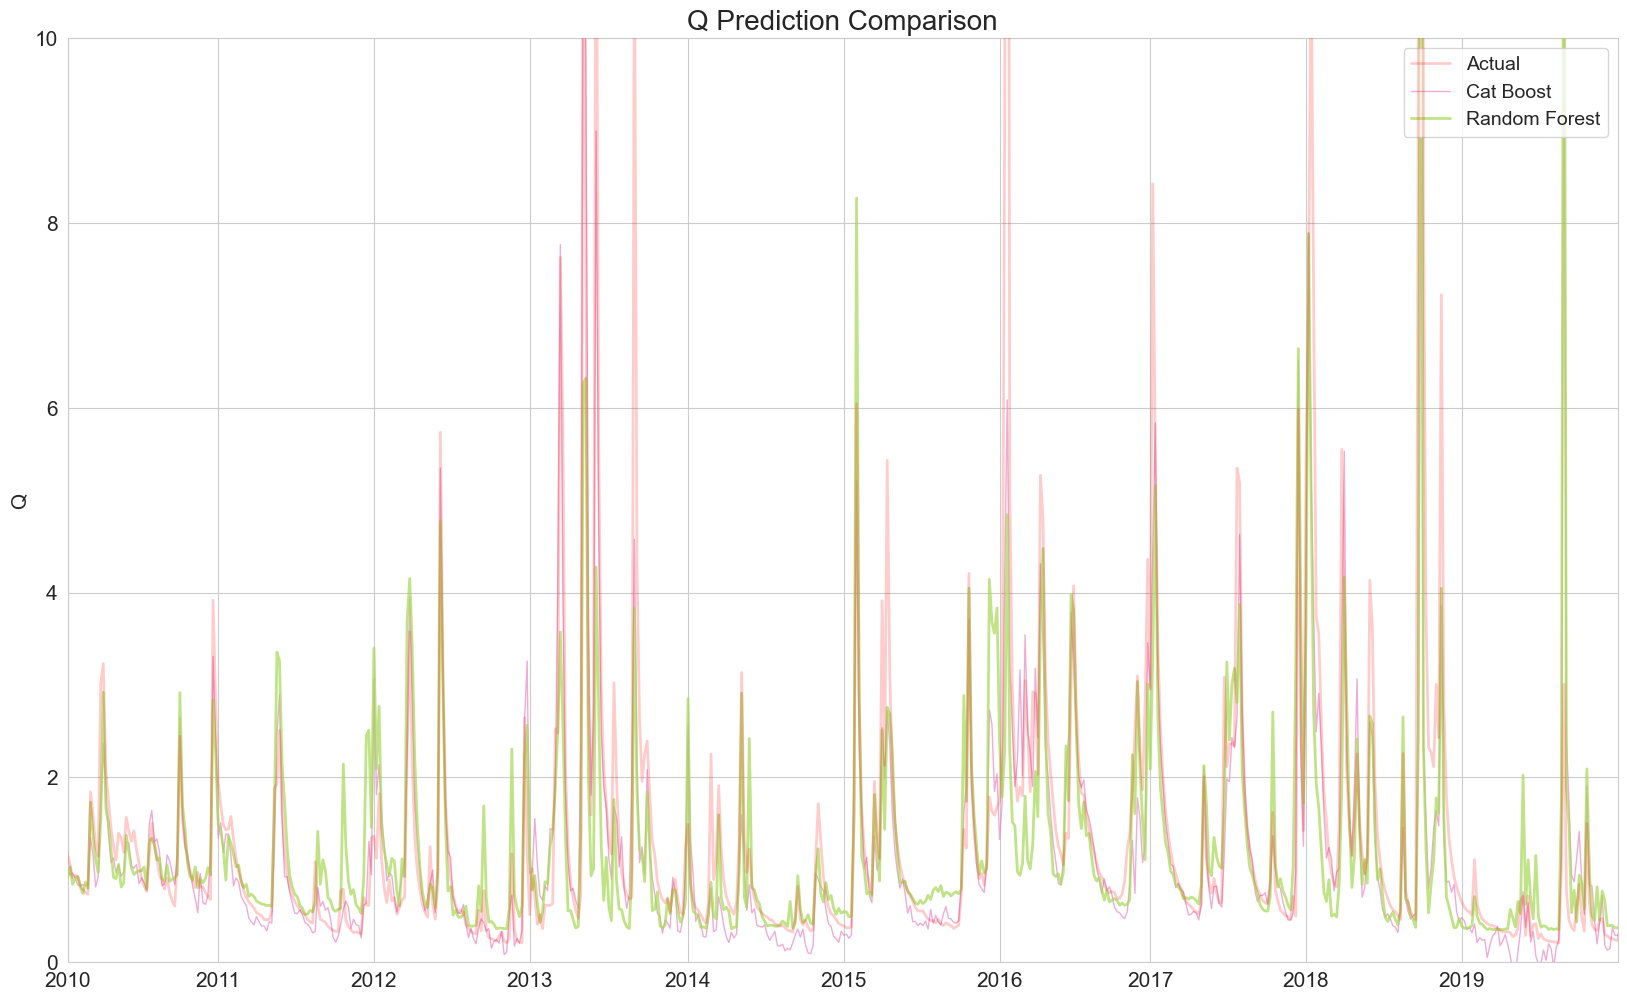

In [77]:
fig, ax = plt.subplots(figsize=(20, 12))

# Plotting code
ax.plot(test_set["Date"], test_set["Q"], label="Actual", lw=2, alpha=0.2, zorder=10, color="red", ls="-")
ax.plot(test_set["Date"], test_set["Q_predicted_CatBoost"], label="Cat Boost", lw=1, alpha=0.7, zorder=2, color=colors2[3])
ax.plot(test_set["Date"], test_set["Q_predicted_RandomForest"], label="Random Forest", lw=2, alpha=0.7, zorder=3, color=colors2[4])

# Add labels and title
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.xaxis.label.set_size(12)
ax.set_ylabel("Q", fontdict={'fontsize': 15})
ax.set_title("Q Prediction Comparison", fontdict={'fontsize': 20})
#-----------------------------------------------------------------
# HERE SET THE X-AXIS TO DISPLAY THE AREA WE WANT FOR OUR MODELS!

ax.set_xlim(pd.Timestamp("2014-01-01"), pd.Timestamp("2015-08-31"))
ax.set_ylim(0, 10)
#-----------------------------------------------------------------

ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)


# Add legend
ax.legend(fontsize="14",loc="upper right")


# Define the update function for the animation
def update(frame):
    ax.set_xlim(ax.get_xlim()[0] + 0.015, ax.get_xlim()[1] + 0.015)
    return ax



# Create the animation
#animation = FuncAnimation(fig, update, frames=range(1200), interval=20)
#animation.save('./output/model_animation.mp4', writer='ffmpeg')
plt.show()


In [10]:
import hydroeval as he
he.nse(data_csv["Q"], data_csv["Q_predicted_CatBoost"]) #implement it as a scorer in the ML-models!

TypeError: missing a required argument: 'y_true'